# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels_20percent.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels_20percent.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(25192, 120)

In [4]:
dataset.kdd_test_2labels.shape

(11850, 120)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    
    y_train = y_output.values
    y_test = y_test.values
    
    x_train = np.hstack((x_train, y_train))
    x_test = np.hstack((x_test, np.random.normal(size = (x_test.shape[0], y_train.shape[1]))))
    
    #x_test = np.hstack((x_test, y_test))
    
preprocess.x_train.std()

0.98738571771904593

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 120
    classes = 2
    hidden_encoder_dim = 120
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 120
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            self.x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
            self.y = tf.slice(self.x_hat, [0,input_dim-2], [-1,-1])

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)

            #loss = tf.clip_by_value(loss, -1e-2, 1e-2)
            #loss = tf.where(tf.is_nan(loss), 1e-2, loss)
            #loss = tf.where(tf.equal(loss, -1e-2), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-2), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score_20', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_only_vae_loss_nsl_kdd_/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    #print("Step {} | Training Loss:".format(epoch), end = " " )
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                       net.regularized_loss, 
                                                       ], #net.summary_op
                                                      feed_dict={net.x: x_train[i,:], 
                                                                 net.y_: y_train[i,:], 
                                                                 net.keep_prob:1, net.lr:lr})
                        train_batch()

                        count = 10
                        while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1 and count > 1):
                            print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_{}_features count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()
                            count -=1

                        #summary_writer_train.add_summary(summary_str, epoch)
                        #if(train_loss > 1e9):

                        #print("{:.6f}".format(train_loss), end = ", " )

                    #print("")
                    valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})


                    accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})
                   
                    #print("*************** \n")
                    print("Step {} | Training Loss: {:.6f} | Test Loss: {:6f} | Test Accuracy: {:.6f}".format(epoch, train_loss, test_loss, accuracy))
                    #print("*************** \n")
                    #print("Accuracy on Test data: {}".format(accuracy))


                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        
                      
                        
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:

                        #net.saver.save(sess, "dataset/tf_vae_only_vae_loss_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                        #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                        #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})
                        Train.best_acc = accuracy

                        if(not np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_vae_only_vae_loss_nsl_kdd_/hidden layers_{}_features count_{}/model"
                                       .format(epochs,h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):
                                                  (curr_pred, 
                                                   Train.result(epochs*len(lrs), f, h,valid_accuracy, accuracy, time.perf_counter() - start_time))})



In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4, 6]

    epochs = [30]
    lrs = [1e-2, 1e-2/4, 1e-2/4]
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f, lrs)
        

Current Layer Attributes - epochs:30 hidden layers:2 features count:4
Step 1 | Training Loss: 0.000362 | Test Loss: 0.013134 | Test Accuracy: 0.597131
Step 2 | Training Loss: 0.000099 | Test Loss: 0.010398 | Test Accuracy: 0.668354
Step 3 | Training Loss: 0.000079 | Test Loss: 0.008393 | Test Accuracy: 0.692321
Step 4 | Training Loss: 0.000968 | Test Loss: 0.008005 | Test Accuracy: 0.636118
Step 5 | Training Loss: 0.001145 | Test Loss: 0.012598 | Test Accuracy: 0.555949
Step 6 | Training Loss: 0.002206 | Test Loss: 0.013969 | Test Accuracy: 0.574430
Step 7 | Training Loss: 0.000955 | Test Loss: 0.009893 | Test Accuracy: 0.721688
Step 8 | Training Loss: 0.001814 | Test Loss: 0.009546 | Test Accuracy: 0.732827
Step 9 | Training Loss: 0.001614 | Test Loss: 0.008881 | Test Accuracy: 0.754093
Step 10 | Training Loss: 0.000052 | Test Loss: 0.011515 | Test Accuracy: 0.717215
Step 11 | Training Loss: 0.000489 | Test Loss: 0.012149 | Test Accuracy: 0.700591
Step 12 | Training Loss: 0.000405 | T

Step 10 | Training Loss: 0.000247 | Test Loss: 0.018225 | Test Accuracy: 0.659072
Step 11 | Training Loss: 0.000301 | Test Loss: 0.026819 | Test Accuracy: 0.698650
Step 12 | Training Loss: 0.000370 | Test Loss: 0.017283 | Test Accuracy: 0.683460
Step 13 | Training Loss: 0.000447 | Test Loss: 0.058839 | Test Accuracy: 0.682869
Step 14 | Training Loss: 0.001002 | Test Loss: 0.014891 | Test Accuracy: 0.744810
Step 15 | Training Loss: 0.000106 | Test Loss: 0.016668 | Test Accuracy: 0.676456
Step 16 | Training Loss: 0.000787 | Test Loss: 0.018100 | Test Accuracy: 0.694515
Step 17 | Training Loss: 0.000415 | Test Loss: 0.017471 | Test Accuracy: 0.700759
Step 18 | Training Loss: 0.000305 | Test Loss: 0.012521 | Test Accuracy: 0.734684
Step 19 | Training Loss: 0.000713 | Test Loss: 0.015644 | Test Accuracy: 0.687679
Step 20 | Training Loss: 0.001715 | Test Loss: 0.016129 | Test Accuracy: 0.761772
Step 21 | Training Loss: 0.000935 | Test Loss: 0.015142 | Test Accuracy: 0.759325
Step 22 | Traini

Step 20 | Training Loss: 0.000776 | Test Loss: 0.014187 | Test Accuracy: 0.673418
Step 21 | Training Loss: 0.000084 | Test Loss: 0.017613 | Test Accuracy: 0.651814
Step 22 | Training Loss: 0.000355 | Test Loss: 0.021675 | Test Accuracy: 0.542363
Step 23 | Training Loss: 0.000246 | Test Loss: 0.019236 | Test Accuracy: 0.693080
Step 24 | Training Loss: 0.000424 | Test Loss: 0.028065 | Test Accuracy: 0.673502
Step 25 | Training Loss: 0.000047 | Test Loss: 0.023239 | Test Accuracy: 0.493502
Step 26 | Training Loss: 0.017611 | Test Loss: 0.021577 | Test Accuracy: 0.718481
Step 27 | Training Loss: 0.000592 | Test Loss: 0.016827 | Test Accuracy: 0.402447
Step 28 | Training Loss: 0.000341 | Test Loss: 0.012375 | Test Accuracy: 0.772236
Step 29 | Training Loss: 0.000116 | Test Loss: 0.015174 | Test Accuracy: 0.716624
Step 30 | Training Loss: 0.000670 | Test Loss: 0.018526 | Test Accuracy: 0.771392
Step 1 | Training Loss: 0.000631 | Test Loss: 0.015689 | Test Accuracy: 0.763882
Step 2 | Training

Step 30 | Training Loss: 0.000424 | Test Loss: 0.016049 | Test Accuracy: 0.796793
Step 1 | Training Loss: 0.000281 | Test Loss: 0.016328 | Test Accuracy: 0.790295
Step 2 | Training Loss: 0.000713 | Test Loss: 0.019271 | Test Accuracy: 0.784051
Step 3 | Training Loss: 0.000084 | Test Loss: 0.016628 | Test Accuracy: 0.788354
Step 4 | Training Loss: 0.000736 | Test Loss: 0.017071 | Test Accuracy: 0.788101
Step 5 | Training Loss: 0.000430 | Test Loss: 0.015154 | Test Accuracy: 0.789789
Step 6 | Training Loss: 0.000577 | Test Loss: 0.014199 | Test Accuracy: 0.795359
Step 7 | Training Loss: 0.000035 | Test Loss: 0.013438 | Test Accuracy: 0.794346
Step 8 | Training Loss: 0.000319 | Test Loss: 0.016169 | Test Accuracy: 0.790802
Step 9 | Training Loss: 0.000377 | Test Loss: 0.013837 | Test Accuracy: 0.795190
Step 10 | Training Loss: 0.001227 | Test Loss: 0.016666 | Test Accuracy: 0.791646
Step 11 | Training Loss: 0.000039 | Test Loss: 0.017124 | Test Accuracy: 0.784810
Step 12 | Training Loss: 

Step 8 | Training Loss: 0.000375 | Test Loss: 0.004768 | Test Accuracy: 0.181603
Step 9 | Training Loss: 0.000654 | Test Loss: 0.004444 | Test Accuracy: 0.181603
Step 10 | Training Loss: 0.000061 | Test Loss: 0.002316 | Test Accuracy: 0.839578
Step 11 | Training Loss: 0.000737 | Test Loss: 0.002810 | Test Accuracy: 0.841772
Step 12 | Training Loss: 0.000309 | Test Loss: 0.003572 | Test Accuracy: 0.839662
Step 13 | Training Loss: 0.000994 | Test Loss: 0.002759 | Test Accuracy: 0.838059
Step 14 | Training Loss: 0.000333 | Test Loss: 0.004649 | Test Accuracy: 0.181688
Step 15 | Training Loss: 0.000315 | Test Loss: 0.003827 | Test Accuracy: 0.836793
Step 16 | Training Loss: 0.000633 | Test Loss: 0.003627 | Test Accuracy: 0.834937
Step 17 | Training Loss: 0.000075 | Test Loss: 0.003328 | Test Accuracy: 0.838650
Step 18 | Training Loss: 0.000308 | Test Loss: 0.004057 | Test Accuracy: 0.186245
Step 19 | Training Loss: 0.000095 | Test Loss: 0.004268 | Test Accuracy: 0.183038
Step 20 | Training

Step 18 | Training Loss: 0.000318 | Test Loss: 0.004584 | Test Accuracy: 0.841603
Step 19 | Training Loss: 0.000026 | Test Loss: 0.004050 | Test Accuracy: 0.840844
Step 20 | Training Loss: 0.000127 | Test Loss: 0.003953 | Test Accuracy: 0.839072
Step 21 | Training Loss: 0.000228 | Test Loss: 0.003938 | Test Accuracy: 0.844051
Step 22 | Training Loss: 0.000011 | Test Loss: 0.004556 | Test Accuracy: 0.847764
Step 23 | Training Loss: 0.000205 | Test Loss: 0.004250 | Test Accuracy: 0.845570
Step 24 | Training Loss: 0.000174 | Test Loss: 0.004049 | Test Accuracy: 0.843713
Step 25 | Training Loss: 0.000194 | Test Loss: 0.004330 | Test Accuracy: 0.854008
Step 26 | Training Loss: 0.000182 | Test Loss: 0.004425 | Test Accuracy: 0.852743
Step 27 | Training Loss: 0.000402 | Test Loss: 0.003985 | Test Accuracy: 0.855274
Step 28 | Training Loss: 0.000103 | Test Loss: 0.004507 | Test Accuracy: 0.852996
Step 29 | Training Loss: 0.000197 | Test Loss: 0.004473 | Test Accuracy: 0.854008
Step 30 | Traini

Step 28 | Training Loss: 0.000005 | Test Loss: 0.004428 | Test Accuracy: 0.726160
Step 29 | Training Loss: 0.000033 | Test Loss: 0.005109 | Test Accuracy: 0.724557
Step 30 | Training Loss: 0.000264 | Test Loss: 0.004170 | Test Accuracy: 0.724895
Step 1 | Training Loss: 0.000090 | Test Loss: 0.004489 | Test Accuracy: 0.724051
Step 2 | Training Loss: 0.000392 | Test Loss: 0.004400 | Test Accuracy: 0.725907
Step 3 | Training Loss: 0.000095 | Test Loss: 0.004250 | Test Accuracy: 0.726245
Step 4 | Training Loss: 0.000093 | Test Loss: 0.004119 | Test Accuracy: 0.726329
Step 5 | Training Loss: 0.000026 | Test Loss: 0.003841 | Test Accuracy: 0.726076
Step 6 | Training Loss: 0.000009 | Test Loss: 0.003688 | Test Accuracy: 0.711814
Step 7 | Training Loss: 0.000157 | Test Loss: 0.003815 | Test Accuracy: 0.724135
Step 8 | Training Loss: 0.000217 | Test Loss: 0.003720 | Test Accuracy: 0.728861
Step 9 | Training Loss: 0.000054 | Test Loss: 0.004057 | Test Accuracy: 0.723797
Step 10 | Training Loss: 

Step 26 | Training Loss: 0.000070 | Test Loss: 0.005266 | Test Accuracy: 0.810211
Step 27 | Training Loss: 0.000223 | Test Loss: 0.005389 | Test Accuracy: 0.806160
Step 28 | Training Loss: 0.000681 | Test Loss: 0.004994 | Test Accuracy: 0.806835
Step 29 | Training Loss: 0.000149 | Test Loss: 0.005076 | Test Accuracy: 0.805738
Step 30 | Training Loss: 0.000045 | Test Loss: 0.005266 | Test Accuracy: 0.803713
Step 1 | Training Loss: 0.000084 | Test Loss: 0.004844 | Test Accuracy: 0.804726
Step 2 | Training Loss: 0.000647 | Test Loss: 0.004622 | Test Accuracy: 0.809705
Step 3 | Training Loss: 0.000626 | Test Loss: 0.004316 | Test Accuracy: 0.808861
Step 4 | Training Loss: 0.000328 | Test Loss: 0.004756 | Test Accuracy: 0.806835
Step 5 | Training Loss: 0.000330 | Test Loss: 0.004362 | Test Accuracy: 0.809367
Step 6 | Training Loss: 0.000475 | Test Loss: 0.004481 | Test Accuracy: 0.807932
Step 7 | Training Loss: 0.000457 | Test Loss: 0.004881 | Test Accuracy: 0.804979
Step 8 | Training Loss:

Step 6 | Training Loss: 0.007271 | Test Loss: 0.012278 | Test Accuracy: 0.818397
Step 7 | Training Loss: 0.007763 | Test Loss: 0.012295 | Test Accuracy: 0.181603
Step 8 | Training Loss: 0.007663 | Test Loss: 0.012321 | Test Accuracy: 0.181603
Step 9 | Training Loss: 0.006476 | Test Loss: 0.012737 | Test Accuracy: 0.181603
Step 10 | Training Loss: 0.007057 | Test Loss: 0.012602 | Test Accuracy: 0.181603
Step 11 | Training Loss: 0.007147 | Test Loss: 0.012702 | Test Accuracy: 0.181603
Step 12 | Training Loss: 0.007341 | Test Loss: 0.012906 | Test Accuracy: 0.181603
Step 13 | Training Loss: 0.006513 | Test Loss: 0.012692 | Test Accuracy: 0.181603
Step 14 | Training Loss: 0.007036 | Test Loss: 0.012141 | Test Accuracy: 0.181603
Step 15 | Training Loss: 0.006980 | Test Loss: 0.012261 | Test Accuracy: 0.181603
Step 16 | Training Loss: 0.007139 | Test Loss: 0.012137 | Test Accuracy: 0.181603
Step 17 | Training Loss: 0.006968 | Test Loss: 0.012787 | Test Accuracy: 0.181603
Step 18 | Training L

Step 16 | Training Loss: 0.007874 | Test Loss: 0.012142 | Test Accuracy: 0.181603
Step 17 | Training Loss: 0.006762 | Test Loss: 0.011572 | Test Accuracy: 0.181603
Step 18 | Training Loss: 0.006469 | Test Loss: 0.012285 | Test Accuracy: 0.181603
Step 19 | Training Loss: 0.007154 | Test Loss: 0.011888 | Test Accuracy: 0.181603
Step 20 | Training Loss: 0.008018 | Test Loss: 0.011656 | Test Accuracy: 0.181603
Step 21 | Training Loss: 0.006799 | Test Loss: 0.012071 | Test Accuracy: 0.181603
Step 22 | Training Loss: 0.006686 | Test Loss: 0.011731 | Test Accuracy: 0.181603
Step 23 | Training Loss: 0.006607 | Test Loss: 0.011629 | Test Accuracy: 0.181603
Step 24 | Training Loss: 0.006293 | Test Loss: 0.012200 | Test Accuracy: 0.181603
Step 25 | Training Loss: 0.007230 | Test Loss: 0.011950 | Test Accuracy: 0.181603
Step 26 | Training Loss: 0.006150 | Test Loss: 0.011834 | Test Accuracy: 0.181603
Step 27 | Training Loss: 0.007450 | Test Loss: 0.011649 | Test Accuracy: 0.181603
Step 28 | Traini

Step 21 | Training Loss: 0.000345 | Test Loss: 0.003161 | Test Accuracy: 0.215105
Step 22 | Training Loss: 0.000246 | Test Loss: 0.003886 | Test Accuracy: 0.208523
Step 23 | Training Loss: 0.000827 | Test Loss: 0.003292 | Test Accuracy: 0.209283
Step 24 | Training Loss: 0.000119 | Test Loss: 0.005221 | Test Accuracy: 0.208017
Step 25 | Training Loss: 0.000420 | Test Loss: 0.005094 | Test Accuracy: 0.212236
Step 26 | Training Loss: 0.000190 | Test Loss: 0.002500 | Test Accuracy: 0.213165
Step 27 | Training Loss: 0.000022 | Test Loss: 0.002357 | Test Accuracy: 0.208945
Step 28 | Training Loss: 0.000034 | Test Loss: 0.002900 | Test Accuracy: 0.208186
Step 29 | Training Loss: 0.000719 | Test Loss: 0.001875 | Test Accuracy: 0.210802
Step 30 | Training Loss: 0.000245 | Test Loss: 0.003874 | Test Accuracy: 0.208776
Current Layer Attributes - epochs:30 hidden layers:6 features count:32
Step 1 | Training Loss: 0.002076 | Test Loss: 0.006935 | Test Accuracy: 0.804304
Step 2 | Training Loss: 0.00

In [10]:
dict1 = {}
dict2 = []
for k, (v1, v2) in Train.predictions.items():
    dict1.update({k: v1})
    dict2.append(v2)
    

In [11]:
Train.predictions = dict1
Train.results = dict2

In [12]:
df_results = pd.DataFrame(Train.results)

In [14]:
df_results.sort_values(by = 'test_score_20', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score_20,time_taken
5,90,8,4,0.874603,0.859156,158.698199
4,90,4,4,0.620635,0.855865,95.442408
8,90,4,6,0.557540,0.849114,12.876647
7,90,32,4,0.905159,0.829283,67.209650
0,90,4,2,0.866667,0.829198,43.775972
9,90,8,6,0.467063,0.818397,36.676859
10,90,16,6,0.466270,0.818397,41.939128
11,90,32,6,0.457936,0.818397,54.003071
3,90,32,2,0.925000,0.808523,11.690363
2,90,16,2,0.871429,0.789198,41.652364


In [15]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_predictions-.pkl")
df_results.to_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_scores-.pkl")

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.5897  0.4103]
 [ 0.081   0.919 ]]


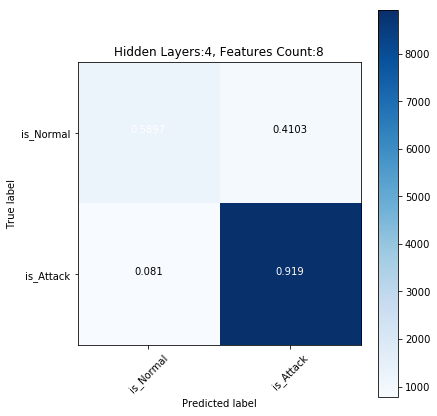

In [17]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)